# Finding Government Clients in Procurement History

* *This notebook is part of the [Government Procurement Queries](https://github.com/antontarasenko/gpq) project*

Finding clients among hundreds of government agencies may be burdensome. The history of government purchases helps narrow search to several agencies that have already bought goods and services like yours. I show how to do it with BigQuery.

You can re-run these examples with your parameters. Practical results often require specifying your company's industry, location, and size in the `where` clause.

*Note:* If you haven't read the [previous part](http://nbviewer.jupyter.org/github/antontarasenko/gpq/blob/master/notebooks/contracts_intro.ipynb) of this series, I strongly recommend starting there. It describes how to re-run the code with your parameters.

In [1]:
import gcp.bigquery as bq
import matplotlib.pyplot as mpl

## Government Agencies

Depending on the amount, agencies buy immediately or issue solicitations. For solicitations, the bidder may secure large sales with a single contract:

### The Top 10 most lucrative contracts

In [2]:
%%sql
select
  substr(agencyid, 1, 4) agency_id,
  first(substr(agencyid, 7)) agency_name,
  first(signeddate) first_signeddate,
  solicitationid,
  avg(numberofoffersreceived) solicitation_offers, # expect all `numberofoffersreceived` to be the same within unique `solicitationid`
  count(*) solicitation_transactions,
  sum(dollarsobligated) solicitation_sum_dollarsobligated,
  group_concat(unique(vendorname)) vendors,
from
  gpqueries:contracts.raw
where
  length(solicitationid) > 5
group by
  agency_id, solicitationid
order by
  solicitation_sum_dollarsobligated desc
limit
  10

agency_id,agency_name,first_signeddate,solicitationid,solicitation_offers,solicitation_transactions,solicitation_sum_dollarsobligated,vendors
9700,DEPT OF DEFENSE,11/23/2015,H9400207R0007,2.0,2138,35417842914.8,"""HEALTH NET FEDERAL SERVICES, INC"",""HUMANA MILITARY HEALTHCARE SERVICES, INC."",""UNITEDHEALTH MILITARY & VETERANS SERVICES, LLC"",""HEALTH NET FEDERAL SERVICES, LLC"""
8900,"ENERGY, DEPARTMENT OF",02/25/2016,DE-RP52-06NA27344,3.0,601,14123504697.0,LAWRENCE LIVERMORE NATIONAL SECURITY LIMITED LIABILITY COMPANY
9700,DEPT OF DEFENSE,01/20/2016,W58RGZ10R0010,1.0,306,10394971573.2,SIKORSKY AIRCRAFT CORPORATION
9700,DEPT OF DEFENSE,02/23/2007,M6785407R5000,10.0,1210,10256596597.4,"OSHKOSH TRUCK CORPORATION (0270),INTERNATIONAL MILITARY AND GOVERMENT LIMITED LIABILITY COMPANY,STEWART AND STEVENSON TACTICAL VEHICLE SYSTEMS LIMITED PARTNERSHIP,PROTECTED VEHICLES INCORPORATED,FORCE PROTECTION INDUSTRIES INCORPORATED,GENERAL DYNAMICS LAND SYSTEMS CANADA CORPORATION,BAE SYSTEMS LAND AND ARMAMENTS INCORPORATED (3796)"
9700,DEPT OF DEFENSE,06/01/2006,N0002404R2205,1.0,1067,10000633404.7,"NORTHROP GRUMMAN SHIP SYSTEMS INCORPORATED,HUNTINGTON INGALLS INCORPORATED,""NORTHROP GRUMMAN SHIP SYSTEMS, INC."""
9700,DEPT OF DEFENSE,10/30/2015,N0002408R2103,3.0,161,8402203523.97,BECHTEL MARINE PROPULSION CORPORATION
9700,DEPT OF DEFENSE,01/28/2016,N0002410R2301,2.0,479,7927626649.0,"""AUSTAL USA, LLC"",LOCKHEED MARTIN CORPORATION"
8900,"ENERGY, DEPARTMENT OF",04/15/2009,DE-RP11-08PN38002,3.0,133,7510173633.38,BECHTEL MARINE PROPULSION CORPORATION
9700,DEPT OF DEFENSE,01/29/2013,N0001908R0056,1.0,217,7221293298.34,MCDONNELL DOUGLAS CORPORATION
8900,"ENERGY, DEPARTMENT OF",10/27/2015,DE-RP02-06CH11357,1.0,765,6857171982.04,"""UCHICAGO ARGONNE, LLC"",UCHICAGO ARGONNE LIMITED LIABILITY COMPANY"


But first you need to win a contract.

One important consideration is competition. As a seller, you'd like fewer competitors. The data allows finding the agencies that issue solicitations attracting fewer offers.

Now, few offers per solicitation may imply several things:

- Harsh contract requirements
- Unique goods and services requested
- The agency does not promote its solicitations

These implications make some agencies more attractive for contractors. Let's find such agencies.

### Agencies with less competition at the solicitation stage

In [3]:
%%sql
select
  agency_id, agency_name,
  # the size of an opportunity
  sum(solicitation_sum_dollarsobligated) agency_sum_dollarsobligated,
  # summarizing the number of offers
  avg(solicitation_offers) avg_solicitation_offers,
  nth(11, quantiles(solicitation_offers, 21)) median_solicitation_offers,
  count(solicitation_offers) count_solicitations,
  sum(solicitation_offers) sum_solicitation_offers,
from (
  select
    substr(agencyid, 1, 4) agency_id,
    first(substr(agencyid, 7)) agency_name,
    solicitationid,
    first(numberofoffersreceived) solicitation_offers, # expect all `numberofoffersreceived` to be the same within unique `solicitationid`
    count(*) solicitation_transactions,
    sum(dollarsobligated) solicitation_sum_dollarsobligated,
  from
    gpqueries:contracts.raw
  where
    length(solicitationid) > 5
  group by
    agency_id, solicitationid
)
where
  # excluding solicitations that ended up in small sales
  solicitation_sum_dollarsobligated > 100000
group by
  agency_id, agency_name
having
  # excluding agencies that bought a little in your product category
  agency_sum_dollarsobligated > 1000000 and
  count_solicitations > 100
order by
  avg_solicitation_offers asc

agency_id,agency_name,agency_sum_dollarsobligated,avg_solicitation_offers,median_solicitation_offers,count_solicitations,sum_solicitation_offers
6100,CONSUMER PRODUCT SAFETY COMMISSION,66289886.11,1.30434782609,1,161,210
9568,BROADCASTING BOARD OF GOVERNORS,167934458.85,1.74456521739,1,184,321
7523,CENTERS FOR DISEASE CONTROL AND PREVENTION,31842073031.7,1.76565777645,1,3337,5892
12G2,FOOD SAFETY AND INSPECTION SERVICE,217063936.83,1.85620915033,1,153,284
4900,NATIONAL SCIENCE FOUNDATION,631997416.94,1.90441176471,1,136,259
4740,PUBLIC BUILDINGS SERVICE,16321326527.9,2.06177306798,1,7738,15954
7526,HEALTH RESOURCES AND SERVICES ADMINISTRATION,303363614.76,2.1043956044,1,182,383
1524,DRUG ENFORCEMENT ADMINISTRATION,443825648.97,2.10714285714,1,140,295
3100,NUCLEAR REGULATORY COMMISSION,553886185.3,2.15245478036,1,387,833
1450,BUREAU OF INDIAN AFFAIRS,498829922.28,2.2641815235,2,617,1397


The variable `avg_solicitation_offers` is the mean number of offers received by an agency for all solicitations issued since 2000. It varies in the interval from 1 to 10, so solicitations issued by certain agencies are indeed easier to win than others.

Tips to make these results more relevant for your business:

- Specify your industry with variable `principalnaicscode`
- Specify your product or service with `productorservicecode`
- Specify your geography
- Narrow the time range to recent contracts (variable `fiscal_year`)

See the variables in [`data/contracts.raw.md`](https://github.com/antontarasenko/gpq/blob/master/data/contracts.raw.md).

### Agencies buying from your industry

You can find which agency buys most from the industry you work in. I use IT for example:

In [4]:
%%sql
select
  substr(agencyid, 1, 4) agency_id,
  first(substr(agencyid, 7)) agency_name,
  sum(dollarsobligated) sum_dollarsobligated,
from
  gpqueries:contracts.raw
where
  substr(principalnaicscode, 1, 2) = '51' # NAICS code for "Information"
group by
  agency_id
order by
  sum_dollarsobligated desc
limit
  10

agency_id,agency_name,sum_dollarsobligated
9700,DEPT OF DEFENSE,85953216539.9
8000,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION,6630191673.9
3600,"VETERANS AFFAIRS, DEPARTMENT OF",4543307804.78
4735,FEDERAL ACQUISITION SERVICE,4094123949.54
6920,FEDERAL AVIATION ADMINISTRATION,3062695172.33
7530,CENTERS FOR MEDICARE AND MEDICAID SERVICES,2475477427.69
7014,U.S. CUSTOMS AND BORDER PROTECTION,2315550083.17
1344,PATENT AND TRADEMARK OFFICE,2229125129.98
1900,"STATE, DEPARTMENT OF",1986148969.6
2050,INTERNAL REVENUE SERVICE,1753405642.9


All agencies buy IT and consulting, so you can use other factors to choose the leads. But suppliers in other industries have to find the agency that "specializes" in buying their type of products. This is where the above query becomes useful.

## Timing

Time is the second important factor to explore.

One famous case is the September hike in government purchases:

### Government purchases hike in September

In [5]:
%%sql --module gpq

define query amount_by_month
select
  substr(signeddate, 1, 2) month,
  count(*) transactions,
  sum(dollarsobligated) sum_dollarsobligated,
from
  gpqueries:contracts.raw
group by
  month
order by
  month asc

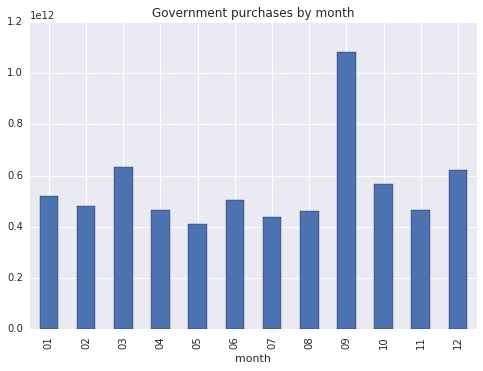

In [6]:
df = bq.Query(gpq.amount_by_month).to_dataframe()
plt = df.set_index('month')['sum_dollarsobligated'].plot(kind='bar', title='Government purchases by month')

September is the last month of a fiscal year. In September, agencies spend the remainder of their annual budget to avoid further budget cuts by the Treasury. It's worth exploring this opportunity in advance because late appearances leave no time for mandatory solicitation procedures.

### Seasonal sales in your industry

In [7]:
%%sql --module gpq

define query seasonal_sales
select
  substr(signeddate, 1, 2) month,
  count(*) transactions,
  sum(dollarsobligated) sum_dollarsobligated,
from
  gpqueries:contracts.raw
where
  substr(principalnaicscode, 1, 2) = '11' # NAICS code for agriculture
  # principalnaicscode contains 'software' # simpler query
group by
  month
order by
  month asc
ignore case

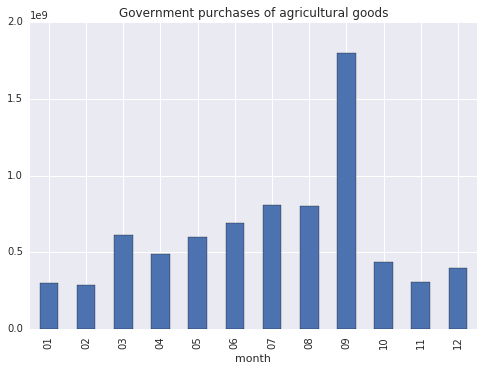

In [8]:
df = bq.Query(gpq.seasonal_sales).to_dataframe()
plt = df.set_index('month')['sum_dollarsobligated'].plot(kind='bar', title='Government purchases of agricultural goods')

Agriculture has evident seasonality, which makes it a good example for timing. Agencies do shopping in the summer, but the overall volume is small: under $8bn in 17 years.

### Trending goods and services

In [9]:
%%sql --module gpq

define query trending_psc
select
  productorservice_id, productorservice_name,
  last(sum_dollarsobligated) / first(sum_dollarsobligated) growth_ratio,
  sum(sum_dollarsobligated) total_dollarsobligated
from (
  select
    fiscal_year,
    substr(productorservicecode, 1, 4) productorservice_id,
    first(productorservicecode) productorservice_name,
    count(*) transactions,
    sum(dollarsobligated) sum_dollarsobligated,
  from
    gpqueries:contracts.raw
  where
    fiscal_year > 2010 and fiscal_year < 2016
    # substr(agencyid, 1, 4) != '9700' # include/exclude DoD
  group by
    productorservice_id, fiscal_year
  order by
    productorservice_id, fiscal_year asc
)
group by
  productorservice_id, productorservice_name
having
  total_dollarsobligated > 10000000 and
  first(sum_dollarsobligated) > 1000000
order by
  growth_ratio desc

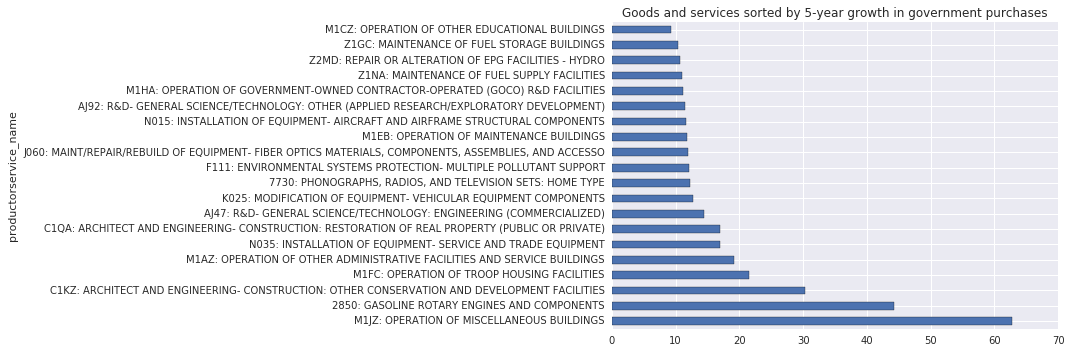

In [10]:
df = bq.Query(gpq.trending_psc).to_dataframe()[:20]
plt = df.set_index('productorservice_name')['growth_ratio'].plot(kind='barh', \
                                                                           title='Goods and services sorted by 5-year growth in government purchases')

In the recent years, agencies buy more construction services. These service groups grow fast and in large volumes.

You can re-run the query to see the full list of services sorted by growth rate.

## Products

The variable `productorservicecode` narrowly encodes the products that agencies buy in each transaction. For codes, see [FPDS.gov](https://www.fpds.gov/wiki/index.php/PSC,_NAICS_and_more) ("PSC Codes"). I show how to find transactions in a broad group (2-digit PSC code):

### Transactions related to a particular product

In [11]:
%%sql
select
  agencyid, signeddate, dollarsobligated, descriptionofcontractrequirement
from
  gpqueries:contracts.raw
where
  fiscal_year > 2010 and fiscal_year < 2016 and
  substr(productorservicecode, 1, 2) = 'AE' and # PSC code for "ECONOMIC GROWTH/PRODUCTIVITY"
  substr(agencyid, 1, 4) != '9700' # exclude DoD, which misclassifies its purchases
order by
  dollarsobligated desc

agencyid,signeddate,dollarsobligated,descriptionofcontractrequirement
7200: AGENCY FOR INTERNATIONAL DEVELOPMENT,12/14/2012,7360000.0,"IGF::CL::IGF - THE PURPOSE OF THIS CONTRACT IS TO STRENGTHEN THE RESILIENCY AND SUSTAINABILITY OF EAST AFRICAN ECONOMIES, TRANS-BOUNDARY FRESHWATER ECOSYSTEMS, AND COMMUNITIES, TARGETING THREE KEY DEVELOPMENT CHALLENGES OF EAST AFRICA THAT ARE LIKEWISE HIGH PRIORITY AREAS FOR THE U.S. GOVERNMENT (USG) AS DESCRIBED IN DETAIL IN SECTION C, STATEMENT OF WORK."
7200: AGENCY FOR INTERNATIONAL DEVELOPMENT,07/16/2014,6030000.0,"IGF::OT::IGF; USAID ENVIRONMENT&BIODIVERSITY TEAM REQUESTS TO INCREMENTALLY FUND PREPARED CONTRACT WITH $6,030,000."
7200: AGENCY FOR INTERNATIONAL DEVELOPMENT,08/13/2015,3718750.0,"IGF::OT::IGF - THIS ACTIVITY WILL LEAD TO STRENGTHENING OF THE PUBLIC DEBT MARKET; ENABLING ACCESS TO NEW AND EFFICIENTLY PRICED SOURCES OF FUNDS FOR THE GOP AS WELL AS OTHER BORROWERS; AND IMPROVED FINANCIAL MANAGEMENT PRACTICES WITHIN THE GOP FOR TAPPING DEMESTIC AND INTERNATIONAL DEBT MARKETS. THE TOTAL ESTIMATED COST FOR THE ACTIVITY IS $18,413,012 OVER FOUR YEARS, OF WHICH $3,718,750 WILL BE USED TO INITIATE THIS ACTIVITY."
7200: AGENCY FOR INTERNATIONAL DEVELOPMENT,09/01/2015,3708539.0,"IGF::OT::IGF; USAID ENVIRONMENT&BIODIVERSITY TEAM REQUESTS RAAO TO INCREMENTALLY FUND TETRA TECH ARD BY $3,708,539 IN SUPPORT OF ONGOING ACTIVITIES UNDER PREPARED PROJECT."
7200: AGENCY FOR INTERNATIONAL DEVELOPMENT,09/27/2015,3249000.0,"IGF::OT::IGF TASK ORDER NUMBER 2 UNDER THE GROWTH, ENTERPRISE, EMPLOYMENT AND LIVELIHOODS (GEEL) IDIQ."
1630: EMPLOYMENT AND TRAINING ADMINISTRATION,04/19/2012,2762010.0,TO PROVIDE COMPREHENSIVE COORDINATION OF GRANTEES CONDUCTING EVALUATIONS OF THEIR WORKFORCE INNOVATION FUND GRANTS AS WELL AS OTHER RELATED ACTIVITIES
7200: AGENCY FOR INTERNATIONAL DEVELOPMENT,03/02/2015,2125000.0,"IGF::OT::IGF THE PURPOSE OF THIS REQM IS TO INCREMENTALLY FUND THE OBLIGATED AMOUNT BY $2,125,000 FROM $2,000,000 TO $4,125,000."
7200: AGENCY FOR INTERNATIONAL DEVELOPMENT,03/14/2014,2000000.0,IGF::OT::IGF THE PURPOSE OF THIS REQUISITION IS TO RESERVE FUNDS OF $2 MILLION FOR PUNJAB ENABLING ENVIRONMENT PROJECT (PEEP) CONTRACT.
"1900: STATE, DEPARTMENT OF",09/28/2012,1871242.43,TV CO-OPS
2700: FEDERAL COMMUNICATIONS COMMISSION,04/03/2015,1850000.0,FCC AUCTIONS - ISAS BIDDING SYSTEM REQUIREMENTS IGF::OT::IGF


These are services related to the research in economic growth and productivity.

Here you can find, for example, the FCC designing its [Integrated Spectrum Auction System](http://wireless.fcc.gov/auctions/default.htm?job=about_isas), which allocates communication frequencies to businesses.

## Conclusions

This way of browsing government contracts can save many hours of calls and negotiations. It's simple and flexible after you learn a dozen or so variables mentioned here. And it's free.

Try it yourself with:

- [The dataset description](https://github.com/antontarasenko/gpq/blob/master/data/contracts.raw.md)
- [GPQ Project](https://github.com/antontarasenko/qpq)

## Contacts

Anton Tarasenko

- [antontarasenko.com](http://antontarasenko.com)
- [antontarasenko@gmail.com](mailto:antontarasenko@gmail.com)